In [1]:
import cv2, os, json, math, time
import pandas as pd
import numpy as np
from collections import Counter, OrderedDict
from zipfile import ZipFile
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon 
from matplotlib.collections import PatchCollection
%matplotlib inline

DATA_DIR = '.../dataset' #@@@ OVERRIDE: Path of folder where the 3 datasets have been downloaded

# FASHION SEGMENTATION DATASETS - Overview
Analysis of 3 publicly-available Fashion Instance Segmentation Datasets: DeepFahsion2, ModaNet, Fashionpedia.  
Download them (see instructions below) and save them in a folder with the following structure to run this script. 

**Dataset Folder Structure**  
- dataset
    - **deepfashion2**
        - train.zip
        - train
            - image
            - annos 
        - validation.zip
        - validation 
            - image
            - annos
        - test.zip
        - test
            - image
        - df2_annos_tr.json
        - df2_annos_val.json
    - **modanet**
        - results
        - dataset
            - modanet
                - logo 
                - annotations
                    - modanet2018_instances_train.json
                    - modanet2018_instances_val.json 
            - coco
                - images
                - annotations

    - **fashionpedia**
        - val_test2020.zip
        - train_2020.zip
        - info_test2020.json
        - instances_attributes_train2020.json
        - instances_attributes_val2020.json


**Datasets Statistics**
<font size="1">

| Dataset | Year | Image Source | #images | #masks | Annotation Format | Avg # masks per image | #categories | IS Model | mAP |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | ---| 
| DeepFashion2 | 2019 | DeepFashion (Liu, 2016) |286,743	| 364,676| Custom |1.27| 13 |Mask R-CNN (He, 2018) | 64%|
| ModaNet | 2019 | PaperDoll (Yamaguchi, 2013) | 55,176 |	265,705	 | COCO |4.82| 13 |DeepLabV3+ |51.1%|
| Fashionpedia | 2020 | Online websites | 48,825 |342,182 | COCO |7.01| 46| Mask R-CNN (He, 2018) |43.15% |

</font>

In [31]:
def plot_annotations(img_path, anns, cats):
    """Display one image, given its path, with annotations
    :return: plot with 2 images
    """
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.subplot(1, 2, 1)
    plt.axis('off')
    imgArray = io.imread(img_path)
    plt.imshow(imgArray)

    plt.subplot(1, 2, 2)
    plt.imshow(imgArray)
    plt.axis('off')

    ax = plt.gca()
    ax.set_autoscale_on(False)

    polygons = []
    color = []
    maps = []

    for ann in anns: #anns = [{annotation1}, {}, {}]
        c = (np.random.random((1, 3))*0.6+0.4).tolist()[0] # for each annotation get 3 random numbers [0, 1]
        for seg in ann['segmentation']:                    # for each segmentation [list of lists] get vertices      
            poly = np.array(seg).reshape((int(len(seg)/2), 2)) # get a matrix len(seg)/2 x 2 (each vertex is an array)
            polygons.append(Polygon(poly))
            color.append(c) 
            if (ann['id'], cats[ann['category_id']-1]['name'], mcolors.to_hex(c)) not in maps:
                maps.append((ann['id'], cats[ann['category_id']-1]['name'], mcolors.to_hex(c)))

    p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
    ax.add_collection(p)
    p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
    ax.add_collection(p)

    #  text
    for i, ann in enumerate(anns):
        print("Segmentation {}:".format(i))
        print("\tCategory: {}".format(cats[ann["category_id"]-1]["name"]))

    # legend
    pops = [mpatches.Patch(color=maps[i][2], label=maps[i][1]) for i in range(len(maps))]
    plt.legend(handles=pops, fontsize='large');

def compute_statistics(dict_numb):
    """Given a dataset, compute the number of images, masks and average number of masks per image
    :return: dataframe 
    """
    stats = pd.DataFrame(dict_numb, index=['Train', 'Val', 'Test'])
    stats['avg(#masks)_per_image'] = round(stats.iloc[:, 1]/stats.iloc[:, 0], 2)
    stats.loc["Total"] = stats.sum().astype(int)
    stats.iloc[-1, -1] = round(stats.iloc[-1, 1]/stats.iloc[-1, 0], 2)
    return stats

def categories_frequency(dataset_annos, name_dataset, relative_frequency=False):
    """Plot the frquency distribution of fashion categories for a set
    :return: plot and dataframe
    """
    counts = []
    num_masks = len(dataset_annos['annotations'])
    cat_count =  dict(OrderedDict(Counter([d['category_id'] for d in dataset_annos['annotations']]).most_common()))
    for k, v in cat_count.items():
        counts.append([dataset_annos['categories'][k-1]['name'], v, round((v/num_masks)*100, 2)])
    df = pd.DataFrame(counts, columns = ['category', '#masks', 'frequency'])

    # Plot
    fig, ax = plt.subplots(figsize=(17,5))
    fig.suptitle(name_dataset.upper(), fontweight='bold')
    x = df['category'].tolist()
    if relative_frequency: 
        y = df['frequency'].tolist()
        ax.set_ylabel('Number of masks (%)')
    else:
        y = df['#masks'].tolist()
        ax.set_ylabel('Number of masks')
    ax.bar(x,y, width=0.2)
    ax.set_title('Number of masks by CATEGORY')
    fig.autofmt_xdate(rotation=45)
    plt.show();
    return df
    

## 1. DeepFashion2 
- Year: 2019, January 
- Paper: [DeepFashion2: A Versatile Benchmark for Detection, Pose Estimation, Segmentation and Re-Identification of Clothing Images](#https://arxiv.org/abs/1901.07973)
- GitHub: [DeepFashion2](#https://github.com/switchablenorms/DeepFashion2)
- Download: [Link](#https://drive.google.com/drive/folders/125F48fsMBz2EF0Cpqk6aaHet5VH399Ok)

In [3]:
with ZipFile(os.path.join(DATA_DIR, 'deepfashion2/train.zip'), 'r') as zipObj:
    df_files_tr = zipObj.namelist()
with ZipFile(os.path.join(DATA_DIR, 'deepfashion2/validation.zip'), 'r') as zipObj:
    df_files_val = zipObj.namelist()
with ZipFile(os.path.join(DATA_DIR, 'deepfashion2/test.zip'), 'r') as zipObj:
    df_files_te = zipObj.namelist()

print("""
        #images      #masks
Train:   {}   |   {}
Val:     {}    |   {}
Test:    {}    |   {}
""".format(
    sum([1 for i in df_files_tr if i.endswith('.jpg')]),
    sum([1 for i in df_files_tr if i.endswith('.json')]),
    sum([1 for i in df_files_val if i.endswith('.jpg')]),
    sum([1 for i in df_files_val if i.endswith('.json')]),
    sum([1 for i in df_files_te if i.endswith('.jpg')]),
    sum([1 for i in df_files_te if i.endswith('.json')])))



        #images      #masks
Train:   191961   |   191961
Val:     32153    |   32153
Test:    62629    |   3



**NB:** Need to convert DeepFashion2 annotations into COCO format. Use function ```df2coco``` in: ```converters.ipynb```

In [4]:
# Convert the annotations into COCO format !!!
df_annos_tr = json.load(open(os.path.join(DATA_DIR, 'deepfashion2/df2_annos_tr.json')))
df_annos_val = json.load(open(os.path.join(DATA_DIR, 'deepfashion2/df2_annos_val.json')))

df_numb = {
        '#images' : [len(df_annos_tr['images']), len(df_annos_val['images']), sum([1 for i in df_files_te if i.endswith('.jpg')])],
        '#masks' : [len(df_annos_tr['annotations']), len(df_annos_val['annotations']), 0]}

df_stats = compute_statistics(df_numb)
df_stats

,#images,#masks,avg(#masks)_per_image
Train,191961,312186,1.63
Val,32153,52490,1.63
Test,62629,0,0.00
Total,286743,364676,1.27


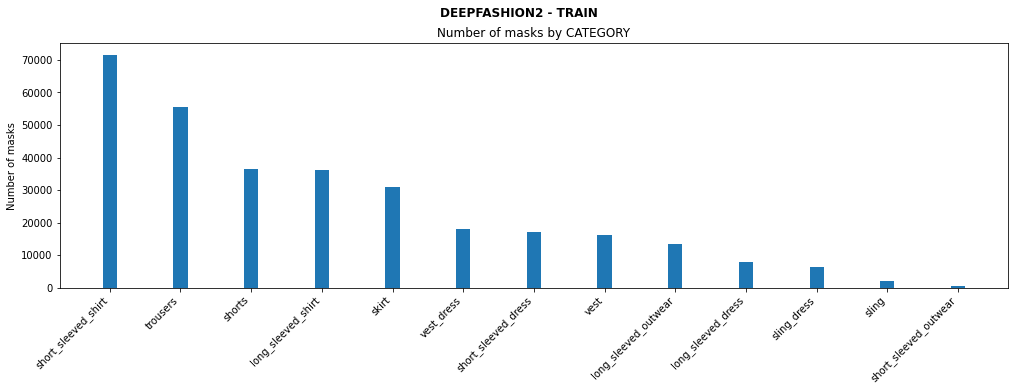

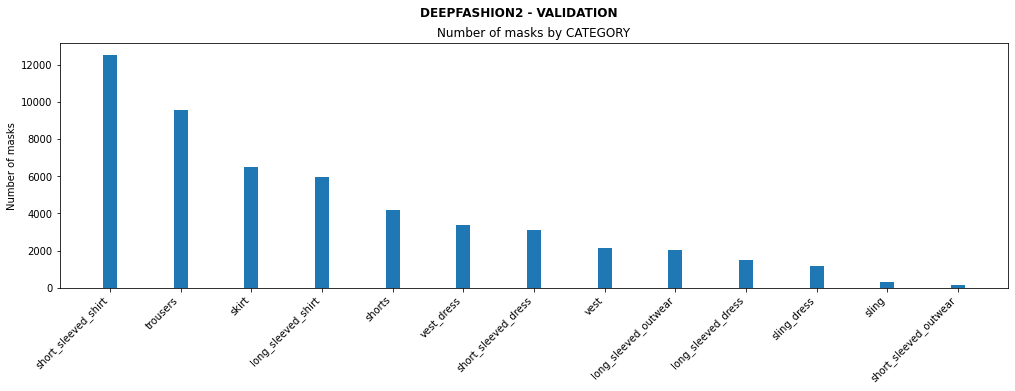

In [32]:
df_cats_stats_tr = categories_frequency(df_annos_tr, 'DeepFashion2 - Train')
df_cats_stats_val = categories_frequency(df_annos_val, 'DeepFashion2 - Validation')

Segmentation 0:
	Category: vest_dress


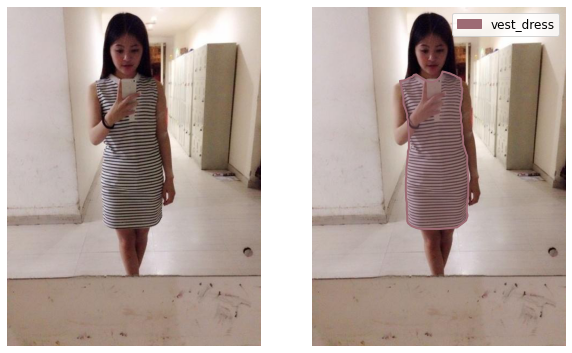

In [5]:
# Plot 1 image with annotations
df_image_id = 300
df_img_path = os.path.join(DATA_DIR, 'deepfashion2/validation/image', str(df_image_id).zfill(6)+'.jpg')
df_cats = df_annos_val['categories']
df_anns = [d for d in df_annos_val['annotations'] if d['image_id'] == df_image_id]

plot_annotations(df_img_path, df_anns, df_cats)

## 2. ModaNet
- Year: 2019, April
- Paper: [ModaNet: A Large-scale Street Fashion Dataset with Polygon Annotations](#https://arxiv.org/pdf/1807.01394.pdf)
- GitHub: [modanet](#https://github.com/eBay/modanet)
- Download: see ```download_modanet.ipynb``` (open in Colab)

In [6]:
moda_annos_tr = json.load(open(os.path.join(DATA_DIR, 'modanet/dataset/modanet/annotations/modanet2018_instances_train.json')))
moda_annos_val = json.load(open(os.path.join(DATA_DIR, 'modanet/dataset/modanet/annotations/modanet2018_instances_val.json')))

moda_numb = {
        '#images' : [len(moda_annos_tr['images']), len(moda_annos_val['images']), 0],
        '#masks' : [len(moda_annos_tr['annotations']), len(moda_annos_val['annotations']), 0]}

moda_stats = compute_statistics(moda_numb)
moda_stats

,#images,#masks,avg(#masks)_per_image
Train,52377,265705,5.07
Val,2799,0,0.00
Test,0,0,NaN
Total,55176,265705,4.82


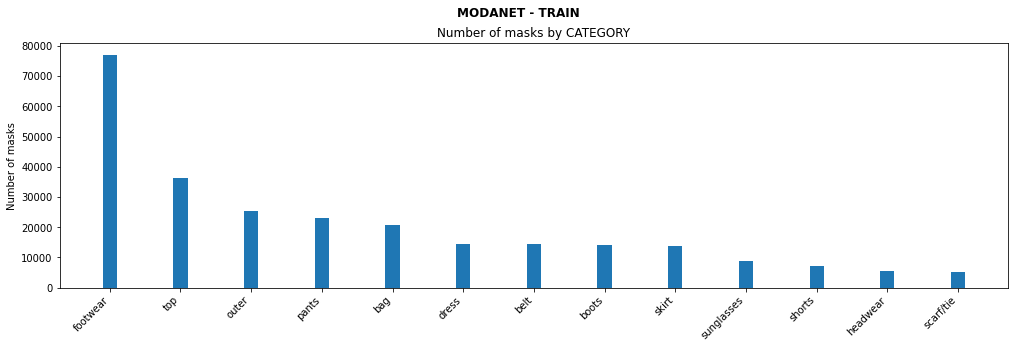

In [33]:
moda_cats_stats_tr = categories_frequency(moda_annos_tr, 'ModaNet - Train')

Segmentation 0:
	Category: top
Segmentation 1:
	Category: skirt
Segmentation 2:
	Category: footwear
Segmentation 3:
	Category: bag


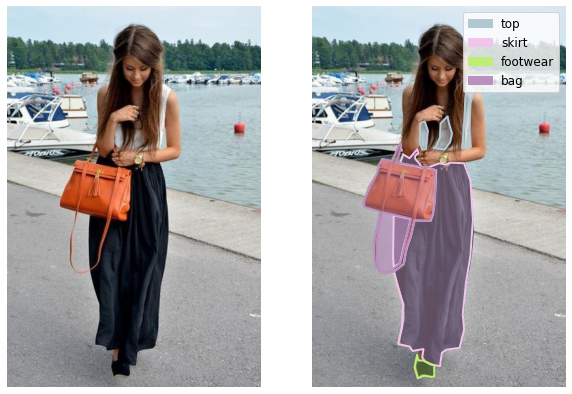

In [7]:
# Plot 1 image with annotations
moda_image_id = 1110465
moda_img_path = os.path.join(DATA_DIR, 'modanet/dataset/coco/images', str(moda_image_id).zfill(7)+'.jpeg')
moda_cats = moda_annos_tr['categories']
moda_anns = [d for d in moda_annos_tr['annotations'] if d['image_id'] == moda_image_id]

plot_annotations(moda_img_path, moda_anns, moda_cats)

## 3. Fashionpedia
- Year: 2020, April
- Paper: [Fashionpedia: Ontology, Segmentation, and an Attribute Localization Dataset](#https://arxiv.org/abs/2004.12276)
- GitHub: [fashionpedia-api](#https://github.com/KMnP/fashionpedia-api)
- Project Page: [Fashionpedia](#https://fashionpedia.github.io/home/index.html)
- Download: [Link](https://github.com/cvdfoundation/fashionpedia)


In [8]:
f_annos_te = json.load(open(os.path.join(DATA_DIR, 'fashionpedia/info_test2020.json')))
f_annos_tr = json.load(open(os.path.join(DATA_DIR, 'fashionpedia/instances_attributes_train2020.json')))
f_annos_val = json.load(open(os.path.join(DATA_DIR, 'fashionpedia/instances_attributes_val2020.json')))

f_numb = {
        '#images' : [len(f_annos_tr['images']), len(f_annos_val['images']), len(f_annos_te['images'])],
        '#masks' : [len(f_annos_tr['annotations']), len(f_annos_val['annotations']), 0]}

f_stats = compute_statistics(f_numb)
f_stats

,#images,#masks,avg(#masks)_per_image
Train,45623,333401,7.31
Val,1158,8781,7.58
Test,2044,0,0.00
Total,48825,342182,7.01


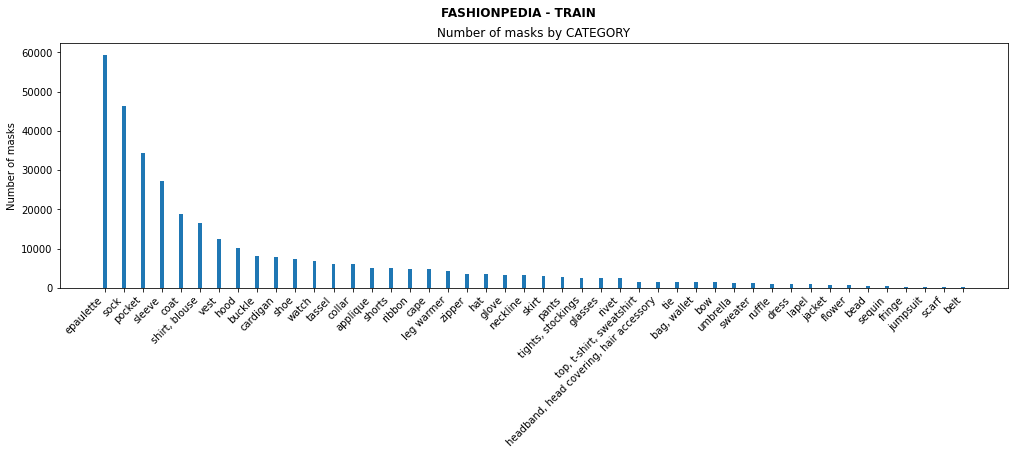

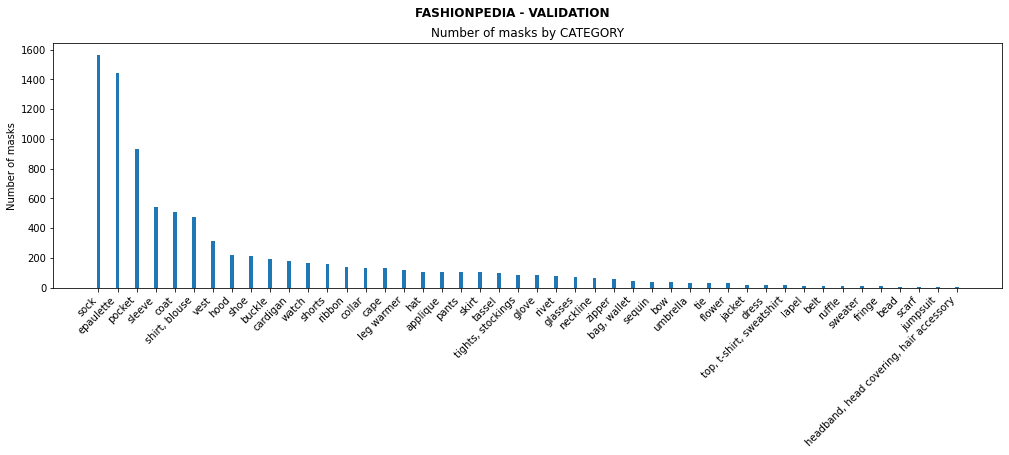

In [34]:
f_cats_stats_tr = categories_frequency(f_annos_tr, 'Fashionpedia - Train')
f_cats_stats_val = categories_frequency(f_annos_val, 'Fashionpedia - Validation')

Segmentation 0:
	Category: cape
Segmentation 1:
	Category: tassel
Segmentation 2:
	Category: epaulette
Segmentation 3:
	Category: epaulette
Segmentation 4:
	Category: sleeve
Segmentation 5:
	Category: sleeve
Segmentation 6:
	Category: vest
Segmentation 7:
	Category: sleeve
Segmentation 8:
	Category: sock
Segmentation 9:
	Category: sock
Segmentation 10:
	Category: hood


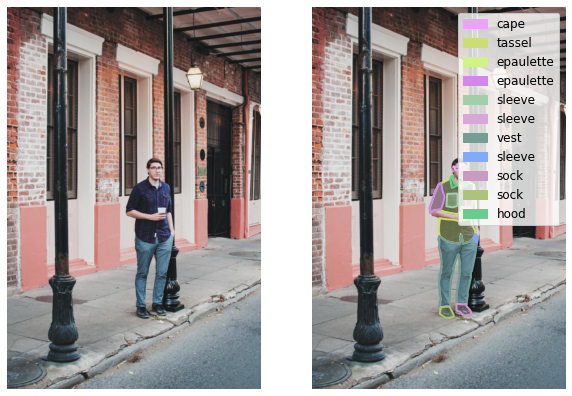

In [9]:
# Plot 1 image with annotations
f_image_id = 18927
f_image_name = [d['file_name'] for d in f_annos_val['images'] if d['id'] == f_image_id][0]
f_img_path = os.path.join(DATA_DIR, 'fashionpedia/test', f_image_name)
f_cats = f_annos_val['categories']
f_anns = [d for d in f_annos_val['annotations'] if d['image_id'] == f_image_id]
f_anns2 = [d for d in f_anns if d['category_id']<27] # If want to visualize only masks of clothes and not masks of clothes parts

plot_annotations(f_img_path, f_anns, f_cats)